In [1]:
import json 
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from urllib.request import urlopen

saveProcessed = True

### Retrieve Drafts

In [2]:
with open(r'../data/civs.txt') as f:
    civs = [x.split(r'/')[-1] for x in f.read().split('\n')]
draftUrls = pd.read_csv(r'../data/kotd6/drafts.csv')

In [3]:
draftDfList = []

for _,row in tqdm(draftUrls.iterrows()):
    if not saveProcessed:
        break
    tmpDf = pd.DataFrame({'Round':[row['Round']], 'Host':[row['Host']], 'Guest':[row['Guest']]})
    for c in ['Admin', 'Host', 'Guest']:
        tmpDf[f'{c}Ban'] = [[]]
        if c=='Admin':
            continue
        tmpDf[f'{c}Pick'] = [[]]
                              
    with urlopen(row['Draft'].replace('draft', r'api/draft')) as url:
        draft = json.loads(url.read().decode())
        
    for d in draft['events']:
        if 'chosenOptionId' not in d:
            continue
        civ = d['chosenOptionId']
        
        if d['actionType']=='ban':
            if d['player']=='NONE':
                tmpDf.loc[0,'AdminBan'].append(civ)
            if d['player']=='HOST':
                tmpDf.loc[0,'HostBan'].append(civ)
            if d['player']=='GUEST':
                tmpDf.loc[0,'GuestBan'].append(civ)
                
        if d['actionType']=='pick':
            if d['player']=='HOST':
                tmpDf.loc[0,'HostPick'].append(civ)
            if d['player']=='GUEST':
                tmpDf.loc[0,'GuestPick'].append(civ)
            
    draftDfList.append(tmpDf)

if not saveProcessed:
    draftDf = pd.read_parquet(r'../processed/kotd6/drafts.parquet')
else:
    draftDf = pd.concat(draftDfList)
    draftDf.to_parquet(r'../processed/kotd6/drafts.parquet', index=False)

63it [01:19,  1.26s/it]


### Process Drafts

In [4]:
# sets where a civ was not admin banned
setsDf = pd.merge(draftDf.groupby('Round',as_index=False)[['Host']].count(), pd.DataFrame({'Civs':civs}), how='cross').pivot(
    index='Round', columns='Civs', values='Host')

banDf = setsDf.copy()
banDf = banDf.applymap(lambda x: 0)
doubleBanDf = banDf.copy()
pickDf = banDf.copy()
doublePickDf = banDf.copy()
banPriorityDf = setsDf.copy()
banPriorityDf = banPriorityDf.applymap(lambda x: [])
pickPriorityDf = banPriorityDf.copy()

for _,row in draftDf.iterrows():           
    for civ in row['AdminBan']:
        setsDf.loc[row['Round'],civ] -= 1
        
    doubleBanned = set(row['HostBan']).intersection(set(row['GuestBan']))
    for civ in doubleBanned:
        doubleBanDf.loc[row['Round'],civ] += 1
        
    doublePicked = set(row['HostPick']).intersection(set(row['GuestPick']))
    for civ in doublePicked:
        doublePickDf.loc[row['Round'],civ] += 1
        
    for i,civ in enumerate(row['HostBan']):
        banDf.loc[row['Round'],civ] += 1
        banPriorityDf.loc[row['Round'],civ] += [i+1]
    
    for i,civ in enumerate(row['GuestBan']):
        banPriorityDf.loc[row['Round'],civ] += [i+1]
        if civ in doubleBanned:
            continue
        banDf.loc[row['Round'],civ] += 1
        
    for i,civ in enumerate(row['HostPick']):
        pickDf.loc[row['Round'],civ] += 1
        pickPriorityDf.loc[row['Round'],civ] += [i+1]
        
    for i,civ in enumerate(row['GuestPick']):
        pickPriorityDf.loc[row['Round'],civ] += [i+1]
        if civ in doublePicked:
            continue
        pickDf.loc[row['Round'],civ] += 1
        
banPctDf_overall = banDf*100/setsDf

### R64 vs R32 Bans

In [5]:
r64Bans = banPctDf_overall.loc['R64'].sort_values(ascending=False)
r32Bans = banPctDf_overall.loc['R32'].sort_values(ascending=False)

r64_topBans = set(r64Bans.index[:10])
r32_topBans = set(r32Bans.index[:10])
bannedInBoth = list(r64_topBans.intersection(r32_topBans))
bannedOverall = list(r64_topBans.union(r32_topBans))

r64_r32_topBans = pd.DataFrame({'R64':r64Bans.loc[bannedOverall],
                                'R32':r32Bans.loc[bannedOverall]}).sort_values('R32', ascending=False)

r64_r32_topBans.index = [c + (' (B)' if c in bannedInBoth else '') for c in r64_r32_topBans.index]

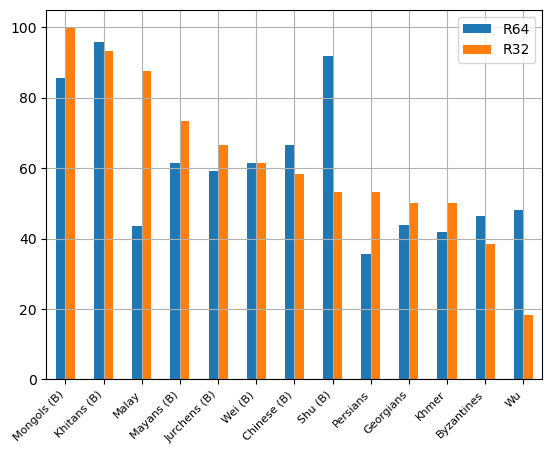

In [6]:
r64_r32_topBans.plot.bar()
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.grid()

### Banned Civs (R32 Onwards)

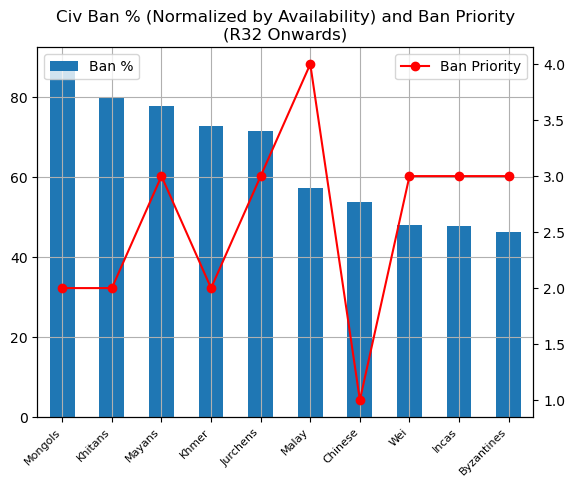

In [7]:
with warnings.catch_warnings(): 
    warnings.filterwarnings('ignore')
    banPctDf = pd.DataFrame({
        'Ban %':banDf.drop('R64').sum(0)*100/setsDf.drop('R64').sum(0),
        'Ban Priority':banPriorityDf.drop('R64').sum().apply(lambda x: np.median(x))
        }).sort_values('Ban %', ascending=False)

ax=banPctDf.iloc[:10]['Ban %'].plot.bar()
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.xlabel('')
plt.grid()
plt.legend(loc='upper left')

ax1=ax.twinx()
banPctDf.iloc[:10]['Ban Priority'].plot(ax=ax1,color='red', marker='o')
plt.legend(loc='upper right')

_ = plt.title('Civ Ban % (Normalized by Availability) and Ban Priority\n(R32 Onwards)')

### Double Banned Civs (R32 Onwards)

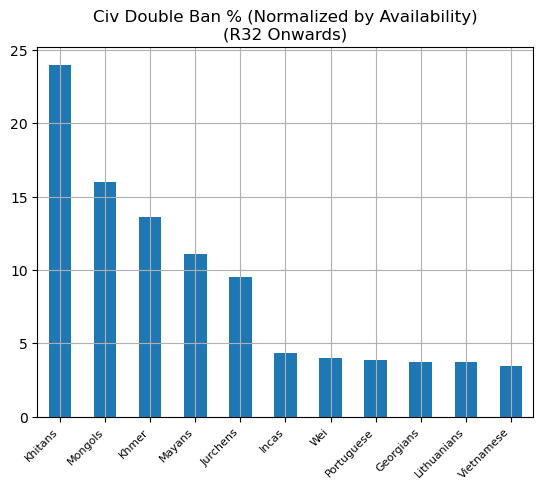

In [8]:
doubleBanPctDf = doubleBanDf.drop('R64').sum(0)*100/setsDf.drop('R64').sum(0)
doubleBanPctDf = doubleBanPctDf.sort_values(ascending=False).pipe(lambda x: x[x!=0])

doubleBanPctDf.plot.bar()
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.xlabel('')
plt.grid()

_ = plt.title('Civ Double Ban % (Normalized by Availability)\n(R32 Onwards)')

### Picked Civs (R32 Onwards)

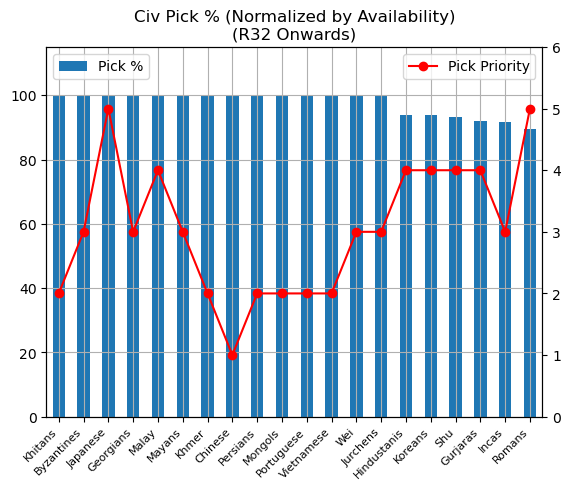

In [9]:
with warnings.catch_warnings(): 
    warnings.filterwarnings('ignore')
    pickPctDf = pd.DataFrame({
        'Pick %':pickDf.drop('R64').sum(0)*100/(setsDf-banDf).drop('R64').sum(0),
        'Pick Priority':pickPriorityDf.drop('R64').sum().apply(lambda x: np.median(x))
        }).sort_values('Pick %', ascending=False)

ax=pickPctDf.iloc[:20]['Pick %'].plot.bar()
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.xlabel('')
plt.ylim(0,115)
plt.legend(loc='upper left')
plt.grid()

ax1=plt.twinx()
pickPctDf.iloc[:20]['Pick Priority'].plot(ax=ax1,color='red', marker='o')
plt.ylim(0,6)
plt.legend(loc='upper right')


_ = plt.title('Civ Pick % (Normalized by Availability)\n(R32 Onwards)')

### Double Picked Civs (R32 Onwards)

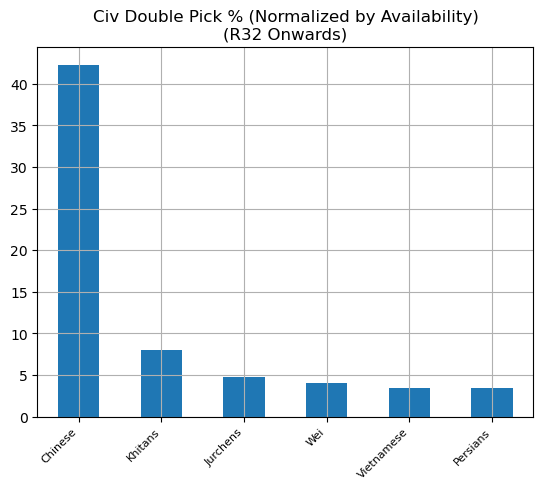

In [10]:
doublePickPctDf = doublePickDf.drop('R64').sum(0)*100/setsDf.drop('R64').sum(0)
doublePickPctDf = doublePickPctDf.sort_values(ascending=False).pipe(lambda x: x[x!=0])

doublePickPctDf.iloc[:20].plot.bar()
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.xlabel('')
plt.grid()

_ = plt.title('Civ Double Pick % (Normalized by Availability)\n(R32 Onwards)')

### Civ Ranking

In [11]:
civRanking = pd.DataFrame({'BanPct':banPctDf['Ban %'], 'DoubleBanPct':doubleBanPctDf, 'PickPct':pickPctDf['Pick %'],
    'DoublePickPct':doublePickPctDf}).fillna(0)
civRanking['Score'] = civRanking.eval('BanPct+DoubleBanPct+DoublePickPct')
civRanking.sort_values(['Score','PickPct'], ascending=False, inplace=True)
civRanking['Rank'] = range(1,len(civs)+1)
if saveProcessed:
    civRanking.to_csv(r'../processed/kotd6/civRanking.csv')
civRanking

,BanPct,DoubleBanPct,PickPct,DoublePickPct,Score,Rank
Civs,,,,,,
Khitans,80.000000,24.000000,100.000000,8.000000,112.000000,1
Mongols,88.000000,16.000000,100.000000,0.000000,104.000000,2
Chinese,53.846154,0.000000,100.000000,42.307692,96.153846,3
Mayans,77.777778,11.111111,100.000000,0.000000,88.888889,4
Khmer,72.727273,13.636364,100.000000,0.000000,86.363636,5
Jurchens,71.428571,9.523810,100.000000,4.761905,85.714286,6
Malay,57.142857,0.000000,100.000000,0.000000,57.142857,7
Wei,48.000000,4.000000,100.000000,4.000000,56.000000,8
Incas,47.826087,4.347826,91.666667,0.000000,52.173913,9


In [12]:
# R64 Civ Ranking
civRanking_r64 = pd.DataFrame({'BanPct':banDf.loc['R64']*100/setsDf.loc['R64'], 
    'DoubleBanPct':doubleBanDf.loc['R64']*100/setsDf.loc['R64'],
    'PickPct':pickDf.loc['R64']*100/setsDf.loc['R64'],
    'DoublePickPct':doublePickDf.loc['R64']*100/setsDf.loc['R64']})
civRanking_r64['Score'] = civRanking_r64.eval('BanPct+DoubleBanPct+DoublePickPct')
civRanking_r64.sort_values(['Score','PickPct'], ascending=False, inplace=True)
civRanking_r64['Rank'] = range(1,len(civs)+1)
if saveProcessed:
    civRanking_r64.to_csv(r'../processed/kotd6/civRanking_r64.csv')